# Indicator Variable Regression Analysis

## Indicator Variables in Econometrics

In econometric models, many explanatory variables are categorical in nature — such as gender, region, treatment status, or education level. These are not inherently numeric, but to include them in a regression framework, we use **indicator variables** (also called **dummy variables**).

### What is an Indicator Variable?

An **indicator variable** is a binary variable that takes the value:
- `1` if the condition is true (e.g., female, treated, urban),
- `0` otherwise (e.g., male, not treated, rural).

This allows us to **capture group-level differences** in regression models.


### Linear Regression with Indicator Variable

Consider the multiple regression model:

$$
Y_i = \beta_0 + \beta_1 X_i + \beta_2 D_i + \varepsilon_i
$$

Where:
- $Y_i$  is the dependent variable,
- $X_i$ is a continuous independent variable,
- $D_i$ is an indicator variable (e.g., gender: 1 for female, 0 for male),
- $\varepsilon_i$ is the error term.

#### Interpretation of Coefficients:

- $beta_0$: Intercept for the base group (e.g., males),
- $beta_1$: Marginal effect of $X$, common across groups (assuming no interaction),
- $beta_2$: Difference in intercept between the base group and the group represented by $D = 1$.

### Simulation Example

In [168]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)

# Simulate data
n = 200
X = np.random.normal(10, 2, size=n)
D = np.random.binomial(1, 0.5, size=n)  # Indicator variable (e.g., Female = 1, Male = 0)

# Generate dependent variable Y
# True model: Y = 2 + 0.5*X + 3*D + error
error = np.random.normal(0, 1, size=n)
Y = 2 + 0.5 * X + 3 * D + error

# Create DataFrame
df = pd.DataFrame({'Y': Y, 'X': X, 'D': D})

# Fit regression model
X_design = sm.add_constant(df[['X', 'D']])
model = sm.OLS(df['Y'], X_design).fit()

summary_text = model.summary().as_text()
print(summary_text)

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     302.9
Date:                Sat, 26 Apr 2025   Prob (F-statistic):           7.98e-61
Time:                        18:14:29   Log-Likelihood:                -284.95
No. Observations:                 200   AIC:                             575.9
Df Residuals:                     197   BIC:                             585.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3140      0.396      5.846      0.0

Intercept (const) = 2.314: This is the expected value of $Y$ when both $X=0$ and $D=0$, i.e., for the base group (e.g., males) with zero value of X.

$X$ coefficient = 0.4596: Holding gender constant, for every one-unit increase in $X$, $Y$ increases by 0.46 units on average.

$D$ coefficient = 3.075: This indicates that, after controlling for $X$, being in group $D=1$ (e.g., female) increases Y by approximately 3.08 units on average compared to the base group (e.g., male).

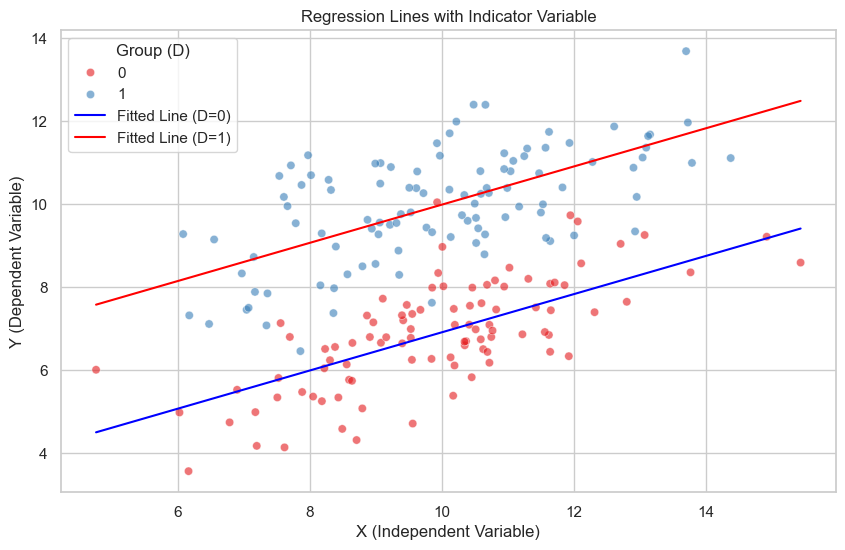

In [169]:
import matplotlib.pyplot as plt
import seaborn as sns

# example using df with X, Y, D
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(x='X', y='Y', hue='D', data=df, palette='Set1', alpha=0.6)

# Add regression lines manually
X_vals = np.linspace(df['X'].min(), df['X'].max(), 100)
Y_fit_D0 = model.params['const'] + model.params['X'] * X_vals
Y_fit_D1 = model.params['const'] + model.params['D'] + model.params['X'] * X_vals

plt.plot(X_vals, Y_fit_D0, color='blue', label='Fitted Line (D=0)')
plt.plot(X_vals, Y_fit_D1, color='red', label='Fitted Line (D=1)')

plt.title("Regression Lines with Indicator Variable")
plt.xlabel("X (Independent Variable)")
plt.ylabel("Y (Dependent Variable)")
plt.legend(title="Group (D)")
plt.show()

In [170]:
from statsmodels.stats.sandwich_covariance import cov_cluster, cov_hac
from statsmodels.iolib.summary2 import summary_col

# Robust standard errors (HC1)
robust_se = model.get_robustcov_results(cov_type='HC1')

# Clustered standard errors by a grouping variable (simulate clusters)
df['cluster_id'] = np.random.choice(20, size=n)  # 20 clusters
cluster_se = model.get_robustcov_results(cov_type='cluster', groups=df['cluster_id'])

# Jackknife standard errors (manually implemented by leave-one-out)
def jackknife_se(model, df):
    n = df.shape[0]
    coefs = []
    for i in range(n):
        df_loo = df.drop(i)
        X_loo = sm.add_constant(df_loo[['X', 'D']])
        y_loo = df_loo['Y']
        model_loo = sm.OLS(y_loo, X_loo).fit()
        coefs.append(model_loo.params.values)
    coefs = np.array(coefs)
    theta_dot = model.params.values
    jk_var = (n - 1) / n * np.sum((coefs - theta_dot)**2, axis=0)
    return np.sqrt(jk_var)

jackknife_se_vals = jackknife_se(model, df)

# Bootstrap standard errors
n_boot = 500
boot_coefs = []
for _ in range(n_boot):
    boot_sample = df.sample(n, replace=True)
    X_boot = sm.add_constant(boot_sample[['X', 'D']])
    y_boot = boot_sample['Y']
    model_boot = sm.OLS(y_boot, X_boot).fit()
    boot_coefs.append(model_boot.params.values)
boot_coefs = np.array(boot_coefs)
boot_se = boot_coefs.std(axis=0)

# Prepare a table comparing different SEs
se_comparison = pd.DataFrame({
    'Coefficient': model.params.values,
    'Std. Error (Default)': model.bse,
    'Robust (HC1)': robust_se.bse,
    'Clustered': cluster_se.bse,
    'Jackknife': jackknife_se_vals,
    'Bootstrap': boot_se
}, index=model.params.index)

se_comparison

,Coefficient,Std. Error (Default),Robust (HC1),Clustered,Jackknife,Bootstrap
const,2.313999,0.395827,0.404768,0.310671,0.410758,0.391042
X,0.459634,0.038584,0.039042,0.027840,0.039624,0.038174
D,3.075117,0.143443,0.142739,0.139228,0.143480,0.135703


## Example 1

Consider the model:

$$
\text{PRICE} = \beta_1 + \delta_1 \cdot \text{UTOWN} + \beta_2 \cdot \text{SQFT} + \gamma (\text{SQFT} \times \text{UTOWN}) + \beta_3 \cdot \text{AGE} + \delta_2 \cdot \text{POOL} + \delta_3 \cdot \text{FPLACE} + e
$$

In [171]:
# Step 1: Import necessary packages
import pandas as pd
import statsmodels.formula.api as smf

# Load the Stata file
file_path = r"D:\Stata-Tutorial\stata\utown.dta"
df = pd.read_stata(file_path)

# Step 3: Run the regression equivalent to Stata command
# Stata: reg price i.utown sqft i.utown#c.sqft age i.pool i.fplace
# Python: price ~ C(utown) + sqft + C(utown):sqft + age + C(pool) + C(fplace)

model = smf.ols(formula="price ~ C(utown) + sqft + C(utown):sqft + age + C(pool) + C(fplace)", data=df)
results = model.fit()

from IPython.display import display, Markdown

# Save summary as text
summary_text = results.summary().as_text()
print(summary_text)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     1113.
Date:                Sat, 26 Apr 2025   Prob (F-statistic):               0.00
Time:                        18:14:35   Log-Likelihood:                -4138.4
No. Observations:                1000   AIC:                             8291.
Df Residuals:                     993   BIC:                             8325.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             24.5000      6

### Combined Test of Significance

In [172]:
print(results.params.index)

Index(['Intercept', 'C(utown)[T.1]', 'C(pool)[T.1]', 'C(fplace)[T.1]', 'sqft',
       'C(utown)[T.1]:sqft', 'age'],
      dtype='object')


In [173]:
# Test the joint null: C(utown)[T.1] = 0 and C(utown)[T.1]:sqft = 0
f_test_result = results.f_test("C(utown)[T.1] = 0, C(utown)[T.1]:sqft = 0")
print(f_test_result)

<F test: F=1954.8294902930443, p=0.0, df_denom=993, df_num=2>


In [174]:
import statsmodels.api as sm

# Refit the model with an explicit design matrix
y = df["price"]
X = sm.add_constant(pd.get_dummies(df[["utown", "sqft", "age", "pool", "fplace"]], drop_first=True))
model = sm.OLS(y, X)
results = model.fit()

# Get Average Marginal Effects summary (for OLS, marginal effects = coefficients)
summary_df = pd.DataFrame({
    "AME": results.params,
    "SE": results.bse,
    "z": results.tvalues,
    "p-value": results.pvalues,
    "CI_lower": results.conf_int()[0],
    "CI_upper": results.conf_int()[1]
})

# Round for neatness
summary_df = summary_df.round(4)
print(summary_df)

            AME      SE        z  p-value  CI_lower  CI_upper
const    6.9119  4.2894   1.6114   0.1074   -1.5054   15.3291
utown   60.1962  0.9715  61.9602   0.0000   58.2897   62.1027
sqft     8.3183  0.1672  49.7588   0.0000    7.9903    8.6464
age     -0.1930  0.0516  -3.7426   0.0002   -0.2942   -0.0918
pool     4.3526  1.2053   3.6113   0.0003    1.9874    6.7177
fplace   1.3988  0.9768   1.4320   0.1525   -0.5180    3.3157


## Example 2

We consider an interaction between two indicator variables, `BLACK` and `FEMALE`, in the following wage equation:

$$
\text{WAGE} = \beta_1 + \beta_2 \cdot \text{EDUC} + \delta_1 \cdot \text{BLACK} + \delta_2 \cdot \text{FEMALE} + \gamma \cdot (\text{BLACK} \times \text{FEMALE}) + e
$$

#### Interpretation:
- **β₁**: Intercept (base group: non-black males)
- **β₂**: Effect of education on wage
- **δ₁**: Difference in wage for black males relative to non-black males
- **δ₂**: Difference in wage for non-black females relative to non-black males
- **γ**: Additional wage difference for black females (beyond the sum of effects of `BLACK` and `


Summary Statistics:

             asian        black         west        south      midwest  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      0.043000     0.112000     0.240000     0.296000     0.240000   
std       0.202959     0.315524     0.427297     0.456719     0.427297   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     1.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

             metro       female      married        hrswk        exper  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      0.780000     0.514000     0.581000    39.952000    26.508000   
std       0.414454     0.500054     0.493642    10.335304    12.854461   
min       0.0000

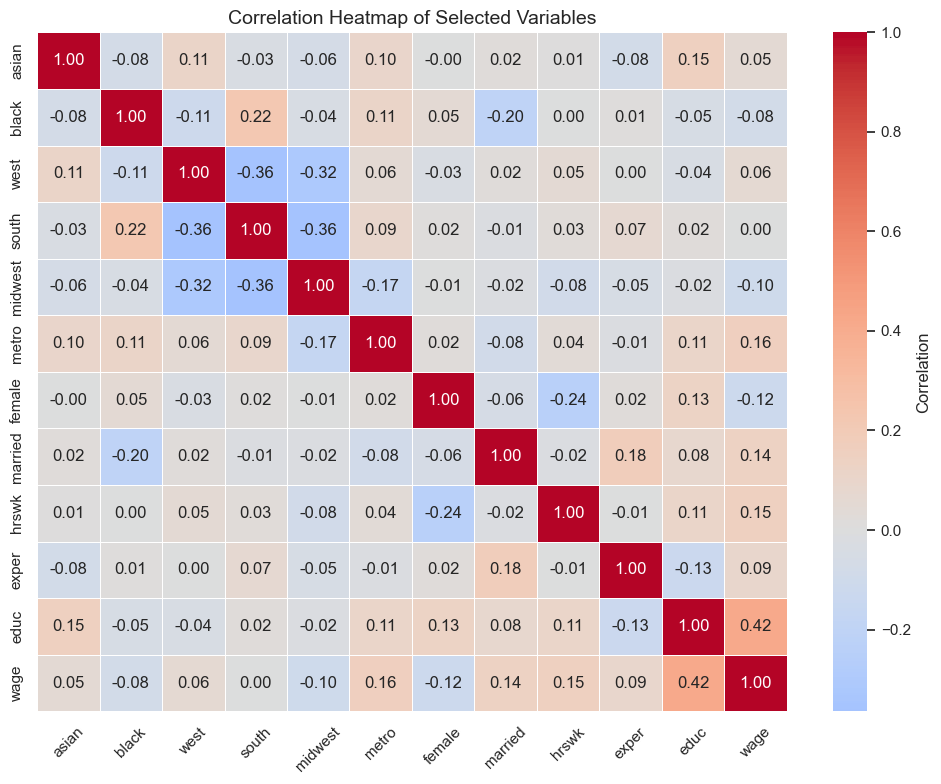

In [175]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load the dataset
path = r"D:\Stata-Tutorial\stata\cps4_small.dta"
df = pd.read_stata(path)

# 2. Variables of interest
vars_of_interest = [
    "asian", "black", "west", "south", "midwest", "metro", "female", "married",
    "hrswk", "exper", "educ", "wage"
]

# 3. Summary statistics
summary_stats = df[vars_of_interest].describe()
print("Summary Statistics:\n")
print(summary_stats)

# 4. Correlation matrix
corr_matrix = df[vars_of_interest].corr()

# 5. Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0,
            linewidths=0.5, cbar_kws={'label': 'Correlation'})
plt.title("Correlation Heatmap of Selected Variables", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [176]:
# Import necessary libraries
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from IPython.display import display, Markdown

# Step 1: Load the dataset
data_path = "D:\\Stata-Tutorial\\stata\\cps4_small.dta"
data = pd.read_stata(data_path)

# Step 2: Define the variables of interest
variables = ["asian", "black", "west", "south", "midwest", "metro", "female", "married", "hrswk", "exper", "educ", "wage"]

# Ensure the required columns are present in the dataset
required_columns = ["wage", "educ", "black", "female"]
if not all(col in data.columns for col in required_columns):
    raise ValueError("Some required columns are missing in the dataset.")

# Step 3: Create the interaction term (BLACK × FEMALE)
data["black_female_interaction"] = data["black"] * data["female"]

# Step 4: Define the regression formula
formula = """
wage ~ educ + black + female + black_female_interaction
"""

# Step 5: Fit the OLS regression model
model = ols(formula, data=data).fit()

# Step 6: Save the summary as text and display centered using Markdown
summary_text = model.summary().as_text()
print(summary_text)

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     65.67
Date:                Sat, 26 Apr 2025   Prob (F-statistic):           2.53e-49
Time:                        18:14:40   Log-Likelihood:                -3853.5
No. Observations:                1000   AIC:                             7717.
Df Residuals:                     995   BIC:                             7741.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

#### Average Marginal Effect

In [177]:
import pandas as pd
import statsmodels.api as sm

# Load dataset
df = pd.read_stata(r"D:\Stata-Tutorial\stata\cps4_small.dta")

# Specify variables
vars_of_interest = [
    "asian", "black", "west", "south", "midwest", "metro", "female", "married",
    "hrswk", "exper", "educ", "wage"
]

# Dependent variable
y = df["wage"]

# Independent variables (drop_first to avoid dummy trap)
X = sm.add_constant(pd.get_dummies(df[vars_of_interest[:-1]], drop_first=True))  # drop 'wage' from X

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit()

# Create AME summary table (coefficients are marginal effects in OLS)
summary_df = pd.DataFrame({
    "AME": results.params,
    "SE": results.bse,
    "z": results.tvalues,
    "p-value": results.pvalues,
    "CI_lower": results.conf_int()[0],
    "CI_upper": results.conf_int()[1]
})

# Round for presentation
summary_df = summary_df.round(4)

# Display result
print(summary_df)

             AME      SE        z  p-value  CI_lower  CI_upper
const   -15.3590  2.5781  -5.9575   0.0000  -20.4181  -10.2998
asian    -1.9337  1.7793  -1.0868   0.2774   -5.4253    1.5579
black    -1.8479  1.1773  -1.5695   0.1168   -4.1583    0.4625
west      0.7632  1.0392   0.7344   0.4629   -1.2762    2.8026
south    -0.8981  1.0022  -0.8961   0.3704   -2.8648    1.0686
midwest  -1.9683  1.0414  -1.8900   0.0591   -4.0119    0.0754
metro     3.6717  0.8769   4.1870   0.0000    1.9509    5.3925
female   -3.9882  0.7391  -5.3956   0.0000   -5.4387   -2.5377
married   1.7644  0.7484   2.3576   0.0186    0.2958    3.2329
hrswk     0.0781  0.0356   2.1921   0.0286    0.0082    0.1481
exper     0.1341  0.0283   4.7386   0.0000    0.0786    0.1896
educ      2.0512  0.1369  14.9816   0.0000    1.7825    2.3199


### Example 3

Consider the Model:
$$
\begin{aligned}
\text{WAGE} &= \beta_1 + \beta_2 \, \text{EDUC} + \beta_3 \, \text{BLACK} + \beta_4 \, \text{FEMALE} \\
&\quad + \beta_5 \, (\text{BLACK} \times \text{FEMALE}) + \delta_1 \, \text{SOUTH} + \delta_2 \, \text{MIDWEST} + \delta_3 \, \text{WEST} + e
\end{aligned}
$$

In [178]:
# Import necessary libraries
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from IPython.display import display, Markdown

# Step 1: Load the dataset
data_path = "D:\\Stata-Tutorial\\stata\\cps4_small.dta"
data = pd.read_stata(data_path)

# Step 2: Define the variables of interest
variables = ["asian", "black", "west", "south", "midwest", "metro", "female", "married", "hrswk", "exper", "educ", "wage"]

# Ensure the required columns are present in the dataset
required_columns = ["wage", "educ", "black", "female", "south", "midwest", "west"]
if not all(col in data.columns for col in required_columns):
    raise ValueError("Some required columns are missing in the dataset.")

# Step 3: Create the interaction term (BLACK × FEMALE)
data["black_female_interaction"] = data["black"] * data["female"]

# Step 4: Define the regression formula
formula = """
wage ~ educ + black + female + black_female_interaction + south + midwest + west
"""

# Step 5: Fit the OLS regression model
model = ols(formula, data=data).fit()

# Step 6: Save the summary as text and display centered using Markdown
summary_text = model.summary().as_text()
print(summary_text)

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     39.71
Date:                Sat, 26 Apr 2025   Prob (F-statistic):           2.32e-49
Time:                        18:14:44   Log-Likelihood:                -3847.1
No. Observations:                1000   AIC:                             7710.
Df Residuals:                     992   BIC:                             7749.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

### Testing the Equivalence of Two Equation

To test the equivalence of the wage equations for the southern region versus the remainder of thecountry (i.e., not south) we create interaction variable for each variable in the regression model with the indicator variable south. The equation we wish to test is

$$
\begin{aligned}
WAGE = \beta_1 &+ \beta_2 EDUC + \delta_1 BLACK \\
              &+ \delta_2 FEMALE + \gamma (BLACK \times FEMALE) + e
\end{aligned}
$$

$$
\begin{aligned}
WAGE = \beta_1 &+ \beta_2 EDUC + \delta_1 BLACK + \delta_2 FEMALE \\
              &+ \gamma (BLACK \times FEMALE) + \theta_1 SOUTH \\
              &+ \theta_2 (EDUC \times SOUTH) + \theta_3 (BLACK \times SOUTH) \\
              &+ \theta_4 (FEMALE \times SOUTH) + \theta_5 (BLACK \times FEMALE \times SOUTH) + e
\end{aligned}
$$

In [179]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Load data
data = pd.read_stata("D:\\Stata-Tutorial\\stata\\cps4_small.dta")

# Create interaction terms
data["black_female_interaction"] = data["black"] * data["female"]
data["educ_south_interaction"] = data["educ"] * data["south"]
data["black_south_interaction"] = data["black"] * data["south"]
data["female_south_interaction"] = data["female"] * data["south"]
data["black_female_south_interaction"] = data["black_female_interaction"] * data["south"]

# Regression models
formula_model1 = """ wage ~ educ + black + female + black_female_interaction """
formula_model2 = """ wage ~ educ + black + female + black_female_interaction + south + educ_south_interaction + black_south_interaction + female_south_interaction + black_female_south_interaction """

model1 = ols(formula_model1, data=data).fit()
model2 = ols(formula_model2, data=data).fit()

# F-test
f_test_result = model1.compare_f_test(model2)

# Print results
print("Summary of Model 1 (Baseline):")
print(model1.summary())
print("\nSummary of Model 2 (Extended):")
print(model2.summary())
print("\nF-test Results:")
print(f_test_result)

Summary of Model 1 (Baseline):
                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     65.67
Date:                Sat, 26 Apr 2025   Prob (F-statistic):           2.53e-49
Time:                        18:14:46   Log-Likelihood:                -3853.5
No. Observations:                1000   AIC:                             7717.
Df Residuals:                     995   BIC:                             7741.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

## Example 3: Log-Linear Model

Suppose we want to estimate log-linear Model

$$
\ln(WAGE) = \beta_1 + \beta_2 EDUC + \beta_3 FEMALE + e
$$

In [180]:
# Import necessary libraries
import pandas as pd
import statsmodels.api as sm
import numpy as np
from IPython.display import display, Markdown

# Step 1: Load the dataset
data_path = "D:\\Stata-Tutorial\\stata\\cps4_small.dta"
data = pd.read_stata(data_path)

# Step 2: Ensure the required columns are present
required_columns = ["wage", "educ", "female"]
if not all(col in data.columns for col in required_columns):
    raise ValueError("Some required columns are missing in the dataset.")

# Step 3: Create the dependent variable (log of wage)
data["ln_wage"] = np.log(data["wage"])

# Step 4: Define the regression formula
formula = "ln_wage ~ educ + female"

# Step 5: Fit the OLS regression model
model = sm.formula.ols(formula, data=data).fit()

# Step 6: Save the summary as text and display centered using Markdown
summary_text = model.summary().as_text()
print(summary_text)

                            OLS Regression Results                            
Dep. Variable:                ln_wage   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     141.7
Date:                Sat, 26 Apr 2025   Prob (F-statistic):           6.88e-55
Time:                        18:14:47   Log-Likelihood:                -749.69
No. Observations:                1000   AIC:                             1505.
Df Residuals:                     997   BIC:                             1520.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6539      0.084     19.601      0.0

#### Simulation for log(wage)

In [181]:
# Step 7: Simulate the effect of education and gender on wage
# Example: Predict ln(wage) for different levels of education and gender
education_levels = [10, 12, 16]  # Example education levels (e.g., high school, college, etc.)
female_values = [0, 1]           # Male (0) and Female (1)

# Create a simulation DataFrame
simulation_data = pd.DataFrame({
    "educ": np.repeat(education_levels, len(female_values)),
    "female": np.tile(female_values, len(education_levels))
})

# Predict ln(wage) for the simulation data
simulation_data["predicted_ln_wage"] = model.predict(simulation_data)

# Convert predicted ln(wage) back to wage (exponentiate)
simulation_data["predicted_wage"] = np.exp(simulation_data["predicted_ln_wage"])

# Display the simulation results
print("\nSimulation Results:")
print(simulation_data)


Simulation Results:
   educ  female  predicted_ln_wage  predicted_wage
0    10       0           2.616352       13.685708
1    10       1           2.373138       10.731015
2    12       0           2.808849       16.590810
3    12       1           2.565635       13.008916
4    16       0           3.193843       24.381938
5    16       1           2.950629       19.117968


## Linear Probability Model

# Linear Probability Model (LPM)

The **Linear Probability Model (LPM)** is a type of regression model used for modeling binary dependent variables. In this model, the outcome variable is binary, taking values of either 0 or 1. The model is called "linear" because it assumes a linear relationship between the independent variables and the probability of the outcome being 1.

### Equation of the Linear Probability Model

The general form of the LPM is given by:

$$
P(Y_i = 1 \mid X_i) = \beta_0 + \beta_1 X_{i1} + \beta_2 X_{i2} + \cdots + \beta_k X_{ik} + \epsilon_i
$$

Where:
- $P(Y_i = 1 \mid X_i)$ is the probability that the dependent variable $Y_i$ takes the value 1 given the set of explanatory variables $X_i$.
- $\beta_0$ is the intercept term.
- $\beta_1$, $\beta_2$, $\dots$, $\beta_k$ are the coefficients of the explanatory variables $X_1$, $X_2$, $\dots$, $X_k$.
- $\epsilon_i$ is the error term, which is assumed to be independently and identically distributed (i.i.d.) with zero mean and constant variance.

### Key Assumptions of the LPM

1. **Linear Relationship**: The model assumes that the probability of $Y_i = 1$ changes linearly with respect to the explanatory variables $X_i$.
2. **Error Term**: The error term $\epsilon_i$ is assumed to have constant variance and is uncorrelated with the explanatory variables.
3. **Homoscedasticity**: The variance of the error term is assumed to be constant across all observations.

### Issues with the Linear Probability Model

1. **Prediction Outside [0, 1]**: One major issue with LPM is that the predicted probabilities can fall outside the valid range of [0, 1]. This is because the linear function can take any value, which is not appropriate for probabilities.
   - Example: A predicted probability of $-0.2$ or $1.5$ is nonsensical as probabilities must lie between 0 and 1.
   
2. **Heteroscedasticity**: The variance of the error term is not constant. This arises because the variance of a binary outcome depends on the value of the probability itself, which varies across observations.

3. **Inefficient Estimates**: The LPM is inefficient in estimating the relationship between the binary outcome and the explanatory variables, as it assumes homoscedasticity (which often doesn't hold for binary outcomes).

### Addressing the Issues

To handle the problem of probabilities falling outside the range [0, 1], one can use alternative models such as:
- **Logistic Regression**: The Logit model, which uses a logistic function to ensure predicted probabilities are bounded between 0 and 1.
- **Probit Model**: Similar to the Logit model, but uses a normal cumulative distribution function.

### Estimation of the LPM

The LPM is typically estimated using **Ordinary Least Squares (OLS)**. The estimation proceeds by minimizing the sum of squared residuals between the observed binary outcomes and the predicted probabilities:

$$
\hat{P}(Y_i = 1 \mid X_i) = \hat{\beta}_0 + \hat{\beta}_1 X_{i1} + \hat{\beta}_2 X_{i2} + \cdots + \hat{\beta}_k X_{ik}
$$

However, despite the issues, the LPM can still provide useful insights, especially when the probability outcomes are close to 0 or 1 and the linear approximation is reasonable.

### Conclusion

While the Linear Probability Model is simple and easy to estimate using OLS, it has limitations, especially in terms of prediction accuracy and efficiency. For more reliable models with binary outcomes, it is recommended to use Logit or Probit regression models, which handle these issues by ensuring that predicted probabilities remain within the valid range of [0, 1] and by providing more efficient estimators.

In [182]:
# Import required libraries
import pandas as pd
import statsmodels.api as sm
import pyreadstat

# Load the dataset from Stata .dta file
df, meta = pyreadstat.read_dta('D:\\Stata-Tutorial\\stata\\coke.dta')
# Check the column names of the dataset
print(df.columns)

Index(['coke', 'pr_pepsi', 'pr_coke', 'disp_pepsi', 'disp_coke', 'pratio'], dtype='object')


### Example 4: Linear Probability Model

In [183]:
# Import necessary libraries
import pandas as pd
import statsmodels.api as sm
from IPython.display import display, Markdown

# Load the dataset from the given path
file_path = r'D:\\Stata-Tutorial\\stata\\coke.dta'
df = pd.read_stata(file_path)

# Inspect the first few rows of the dataset
df.head()

# Define the dependent variable (coke) and independent variables (pratio, disp_coke, disp_pepsi)
X = df[['pratio', 'disp_coke', 'disp_pepsi']]
y = df['coke']

# Add a constant to the model (for the intercept)
X = sm.add_constant(X)

# Fit the Linear Probability Model (LPM) using OLS regression
model = sm.OLS(y, X).fit()

# Save the summary as text and display centered using Markdown
summary_text = model.summary().as_text()
print(summary_text)

                            OLS Regression Results                            
Dep. Variable:                   coke   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     51.67
Date:                Sat, 26 Apr 2025   Prob (F-statistic):           2.64e-31
Time:                        18:14:56   Log-Likelihood:                -748.15
No. Observations:                1140   AIC:                             1504.
Df Residuals:                    1136   BIC:                             1524.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8902      0.065     13.594      0.0

## Treatment Effect Model

# Treatment Effects Model with Dummy Variables

The **Treatment Effects Model** is used to estimate the causal effect of a treatment or intervention on an outcome of interest. This model is commonly used in econometrics and social sciences when the treatment is not randomly assigned, which can lead to selection bias. The treatment effect aims to answer the question: *What would have happened to an individual or unit if they had (or had not) received the treatment?*

A common method to analyze treatment effects is using **dummy variables**, which represent the treatment group (usually as a binary variable indicating whether the unit received the treatment or not).

## Key Concepts

- **Treatment Variable** ($D_i$): A dummy variable where:
  - $D_i = 1$ if unit $i$ receives the treatment (treatment group).
  - $D_i = 0$ if unit $i$ does not receive the treatment (control group).

- **Outcome Variable** ($Y_i$): The dependent variable, representing the outcome of interest that we are trying to analyze, such as test scores, income, health status, etc.

- **Confounders** ($X_i$): The set of covariates (control variables) that could influence both the treatment and the outcome, such as age, gender, education, etc.

### Treatment Effects Model Equation

The treatment effects model can be written as follows:

$$
Y_i = \alpha + \beta D_i + \gamma X_i + \epsilon_i
$$

Where:
- $Y_i$ is the outcome variable for unit $i$.
- $D_i$ is the treatment dummy variable.
- $X_i$ represents a vector of covariates or control variables for unit $i$.
- $\alpha$ is the intercept term.
- $\beta$ is the coefficient for the treatment dummy, representing the **average treatment effect** (ATE).
- $\gamma$ is a vector of coefficients for the covariates $X_i$.
- $\epsilon_i$ is the error term.

### Understanding the Model

1. **Treatment Effect** ($\beta$):
   - The coefficient $\beta$ on $D_i$ measures the **difference in the outcome** between the treatment group and the control group, after controlling for other covariates $X_i$.
   - If $\beta > 0$, it indicates that the treatment increases the outcome, while if $\beta < 0$, it suggests that the treatment reduces the outcome.

2. **Control Variables** ($X_i$):
   - The covariates $X_i$ are included in the model to adjust for confounding factors that could bias the estimate of the treatment effect. These variables can include demographic factors, baseline characteristics, etc.

3. **Error Term** ($\epsilon_i$):
   - The error term represents the unobserved factors that affect the outcome $Y_i$, not captured by the treatment dummy or the covariates.

### Estimation of Treatment Effects

1. **Average Treatment Effect (ATE)**:
   The parameter $\beta$ represents the **Average Treatment Effect (ATE)**, which is the difference in average outcomes between the treated and control groups, adjusted for other covariates.

$$
ATE = \mathbb{E}[Y_i \mid D_i = 1] - \mathbb{E}[Y_i \mid D_i = 0]
$$

2. **Interpretation of $\beta$**:
   - If $\beta = 5$, it means that on average, the treatment increases the outcome $Y_i$ by 5 units compared to the control group.

### Identifying Causal Effects

To establish a causal relationship between the treatment and the outcome, we need to account for potential biases due to confounders. The treatment assignment is not random in most real-world scenarios, which can lead to biased estimates of the treatment effect. This is where econometric techniques such as **matching**, **propensity score matching**, **instrumental variables (IV)**, or **difference-in-differences (DiD)** come into play.

### Example of Estimation with Dummy Variable

Suppose you are studying the effect of a training program (treatment) on income. The dummy variable $D_i$ would be 1 if a person participated in the training program and 0 if they did not. The equation becomes:

$$
\text{Income}_i = \alpha + \beta \cdot \text{Treated}_i + \gamma \cdot \text{Age}_i + \epsilon_i
$$

Where:
- $\text{Income}_i$ is the income of person $i$,
- $\text{Treated}_i$ is the dummy variable (1 if treated, 0 if control),
- $\text{Age}_i$ is a control variable for age,
- $\epsilon_i$ is the error term.

The coefficient $\beta$ tells you the difference in income between those who received the training and those who did not, controlling for age.

### Conclusion

The Treatment Effects Model with a dummy variable is a simple yet powerful tool to estimate the causal effect of an intervention or treatment. It uses a binary treatment variable and adjusts for confounders by including control variables in the model. The coefficient of the treatment dummy represents the average treatment effect, which gives the causal impact of the treatment on the outcome variable.

In cases where the treatment assignment is not random, further techniques such as propensity score matching, instrumental variables, or other advanced methods are needed to improve the accuracy and validity of the treatment effect estimation.


### Example 5: Treatment Effect

#### Regression Equations from Project STAR (Kindergarten)

The models estimated are Ordinary Least Squares (OLS) regressions with `totalscore` as the dependent variable.

**Model (1):**

$$
\text{totalscore}_i = \beta_0 + \beta_1 \, \text{small}_i + \epsilon_i
$$

**Model (2):**

$$
\text{totalscore}_i = \beta_0 + \beta_1 \, \text{small}_i + \beta_2 \, \text{tchexper}_i + \epsilon_i
$$

**Model (3):**

$$
\text{totalscore}_i = \beta_0 + \beta_1 \, \text{small}_i + \beta_2 \, \text{tchexper}_i + \beta_3 \, \text{boy}_i + \beta_4 \, \text{freelunch}_i + \beta_5 \, \text{white\_asian}_i + \epsilon_i
$$

**Model (4):**

$$
\begin{aligned}
\text{totalscore}_i =\,& \beta_0 + \beta_1 \, \text{small}_i + \beta_2 \, \text{tchexper}_i + \beta_3 \, \text{boy}_i \\
& + \beta_4 \, \text{freelunch}_i + \beta_5 \, \text{white\_asian}_i + \beta_6 \, \text{tchwhite}_i \\
& + \beta_7 \, \text{tchmasters}_i + \beta_8 \, \text{schurban}_i + \beta_9 \, \text{schrural}_i + \epsilon_i
\end{aligned}
$$

### Where:
- $\text{totalscore}_i$ = total test score for student \( i \),
- $\text{small}_i$ = dummy for small class size,
- $\text{tchexper}_i$ = teacher's years of experience,
- $\text{boy}_i$ = dummy for male student,
- $\text{freelunch}_i$ = dummy for free lunch eligibility (proxy for low income),
- $\text{white\_asian}_i$ = dummy for race (white or Asian),
- $\text{tchwhite}_i$ = dummy if teacher is White,
- $\text{tchmasters}_i$ = dummy if teacher has a Master's degree,
- $\text{schurban}_i$ = dummy if school is in an urban area,
- $\text{schrural}_i$ = dummy if school is in a rural area,
- $\epsilon_i$ = error term.

                 id          schid         tchid     tchexper       absent  \
count   5786.000000    5786.000000  5.786000e+03  5766.000000  5765.000000   
mean   15593.061701  211001.834255  2.110019e+07     9.306452    10.275108   
std     2694.316767   38381.925365  3.838193e+06     5.767684     9.270640   
min    10133.000000  112038.000000  1.120380e+07     0.000000     0.000000   
25%    13519.750000  176329.000000  1.763290e+07     5.000000     4.000000   
50%    15380.500000  215533.000000  2.155331e+07     9.000000     8.000000   
75%    17242.750000  244764.000000  2.447640e+07    13.000000    14.000000   
max    21580.000000  264945.000000  2.649450e+07    27.000000    79.000000   

         readscore    mathscore   totalscore          boy  white_asian  \
count  5786.000000  5786.000000  5786.000000  5786.000000  5786.000000   
mean    436.729692   485.599032   922.328735     0.513481     0.676633   
std      31.713468    47.693935    73.746597     0.499861     0.467802   
m

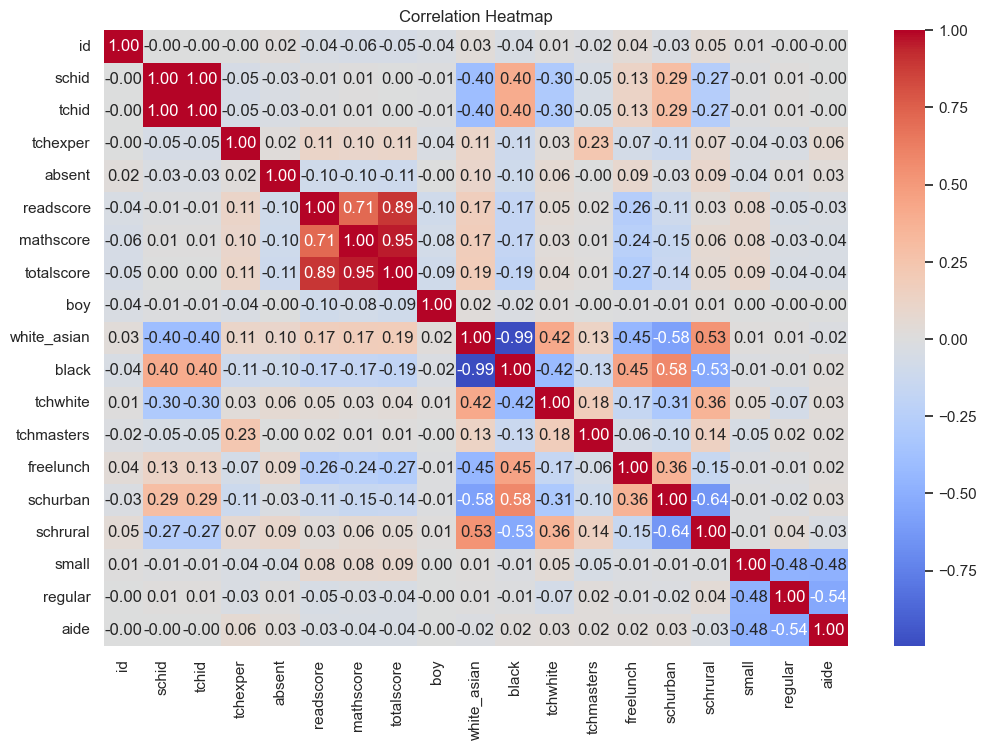

In [184]:
# Step 1: Import Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Step 2: Load the Data
data = pd.read_stata(r"D:\Stata-Tutorial\stata\star.dta")

# Step 3: Statistical Summary
print(data.describe())

# Step 4: Correlation Heatmap
plt.figure(figsize=(12,8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [185]:
# Step 6: Regression Models

# Model 1
model1 = smf.ols('totalscore ~ small', data=data).fit()

# Model 2
model2 = smf.ols('totalscore ~ small + tchexper', data=data).fit()

# Model 3
model3 = smf.ols('totalscore ~ small + tchexper + boy + freelunch + white_asian', data=data).fit()

# Model 4
model4 = smf.ols('totalscore ~ small + tchexper + boy + freelunch + white_asian + tchwhite + tchmasters + schurban + schrural', data=data).fit()

# Step 7: Regression Summary Table

from statsmodels.iolib.summary2 import summary_col

results_table = summary_col([model1, model2, model3, model4],
                            stars=True,
                            model_names=["(1)", "(2)", "(3)", "(4)"],
                            info_dict={
                                'N':lambda x: f"{int(x.nobs)}",
                                'R-squared':lambda x: f"{x.rsquared:.3f}",
                                'Adj. R-squared':lambda x: f"{x.rsquared_adj:.3f}",
                                'BIC':lambda x: f"{x.bic:.3f}"
                            })

print(results_table)



                   (1)         (2)         (3)         (4)    
--------------------------------------------------------------
Intercept      918.2013*** 904.4417*** 923.5747*** 932.1571***
               (1.1550)    (1.9521)    (2.9466)    (3.8382)   
small          13.7406***  14.3067***  13.5468***  13.4739*** 
               (2.1073)    (2.0986)    (2.0098)    (2.0115)   
tchexper                   1.4667***   1.1168***   1.1606***  
                           (0.1670)    (0.1610)    (0.1654)   
boy                                    -14.0436*** -14.0061***
                                       (1.8455)    (1.8425)   
freelunch                              -34.1075*** -32.5148***
                                       (2.0635)    (2.1255)   
white_asian                            11.8272***  16.2084*** 
                                       (2.2104)    (2.7797)   
tchwhite                                           -7.5499*** 
                                                   (2.

### DIFFERENCES-IN-DIFFERENCES ESTIMATION

# Differences-in-Differences (DID) Estimation

Differences-in-Differences (DID) is a quasi-experimental econometric technique used to estimate causal effects by comparing the changes in outcomes over time between a treatment group and a control group. It assumes that, **in the absence of treatment**, the difference between the treatment and control groups would have remained **constant over time** (this is called the **parallel trends assumption**).

The figure below illustrates the DID approach:


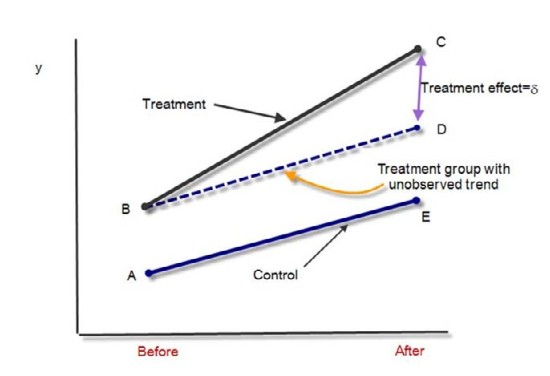

In [186]:
## Upload and Display Image (Python Code)
from IPython.display import Image
Image(filename=r"D:\Stata-Tutorial\DID.jpg")

#### DID Regression Model

We can write the DID regression model as:

$$
Y_{it} = \alpha + \beta \, \text{Post}_t + \gamma \, \text{Treat}_i + \delta \, (\text{Post}_t \times \text{Treat}_i) + \epsilon_{it}
$$

where:

- $Y_{it}$ = Outcome variable for individual $i$ at time $t$ (e.g., test scores, income, health status)
- $\text{Post}_t$ = Dummy variable equal to 1 if time is after the intervention, 0 otherwise
- $\text{Treat}_i$ = Dummy variable equal to 1 if individual $i$ is in the treatment group, 0 otherwise
- $\text{Post}_t \times \text{Treat}_i$ = Interaction term for treatment effect
- $\epsilon_{it}$ = Error term

#### Interpretation of Coefficients

- $\alpha$ : Baseline average outcome for the control group before treatment
- $\beta$ : Common time effect after the intervention (affects both groups)
- $\gamma$ : Baseline difference between treatment and control groups before treatment
- $\delta$ : **Differences-in-Differences (DID) estimator**, i.e., the causal effect of treatment

> **Main interest:** $\delta$ measures the average treatment effect on the treated (ATT).

#### Parallel Trends Assumption

The key assumption for DID validity is the **parallel trends assumption**, which states:

> In the absence of treatment, the treatment group and the control group would have experienced the same changes in outcomes over time.

This assumption is critical for identifying $\delta$.

#### DID with Control Variables

Sometimes we control for additional observed characteristics $X_{it}$:

$$
Y_{it} = \alpha + \beta \, \text{Post}_t + \gamma \, \text{Treat}_i + \delta \, (\text{Post}_t \times \text{Treat}_i) + \mathbf{X}_{it}'\theta + \epsilon_{it}
$$

where:
- $\mathbf{X}_{it}$ = Vector of covariates (e.g., age, gender, baseline scores)
- $\theta$ = Vector of coefficients associated with covariates

Adding controls can improve estimation precision.

## Example 6: DID

In April 1, 1992, New Jersey’s minimum wage was increased from $\$4.25$ to $\$5.05$ per hour, while the minimum wage in Pennsylvania stayed at $4.25 per hour. Card and Krueger collected data on 410 fast food restaurants in New Jersey (the treatment group) and eastern Pennsylvania (the control group). The “before” period is February, 1992, and the “after” period is November, 1992. Using these data they estimate the effect of the “treatment,” raising the New Jersey minimum wage on employment at fast food restaurants in New Jersey.

In [187]:
# Step 1: Load the Data
df = pd.read_stata(r"D:\Stata-Tutorial\stata\njmin3.dta")

# Summarize selected variables
summary_vars = df[['nj', 'd', 'd_nj', 'fte']]
summary = summary_vars.describe()
print(summary)

               nj           d        d_nj         fte
count  820.000000  820.000000  820.000000  794.000000
mean     0.807317    0.500000    0.403659   21.026511
std      0.394647    0.500305    0.490930    9.422746
min      0.000000    0.000000    0.000000    0.000000
25%      1.000000    0.000000    0.000000   14.500000
50%      1.000000    0.500000    0.000000   20.000000
75%      1.000000    1.000000    1.000000   25.500000
max      1.000000    1.000000    1.000000   85.000000


# Regression of `fte` on `nj`, `d`, and `d_nj` (and controls)

We estimate the following three regressions:

**Model (1):**
$$
\begin{aligned}
fte_i = \beta_0 &+ \beta_1 \, \text{nj}_i + \beta_2 \, \text{d}_i + \beta_3 \, \text{d\_nj}_i + u_i
\end{aligned}
$$

**Model (2):**
$$
\begin{aligned}
fte_i = \beta_0 &+ \beta_1 \, \text{nj}_i + \beta_2 \, \text{d}_i + \beta_3 \, \text{d\_nj}_i \\
               &+ \beta_4 \, \text{kfc}_i + \beta_5 \, \text{roys}_i + \beta_6 \, \text{wendys}_i + \beta_7 \, \text{co\_owned}_i + u_i
\end{aligned}
$$

**Model (3):**
$$
\begin{aligned}
fte_i = \beta_0 &+ \beta_1 \, \text{nj}_i + \beta_2 \, \text{d}_i + \beta_3 \, \text{d\_nj}_i \\
               &+ \beta_4 \, \text{kfc}_i + \beta_5 \, \text{roys}_i + \beta_6 \, \text{wendys}_i + \beta_7 \, \text{co\_owned}_i \\
               &+ \beta_8 \, \text{southj}_i + \beta_9 \, \text{centralj}_i + \beta_{10} \, \text{pa1}_i + u_i
\end{aligned}
$$


In [188]:
import pandas as pd

# Load your data
df = pd.read_stata(r"D:\Stata-Tutorial\stata\njmin3.dta")

# Create summaries separately
fte_nj0_d0 = df[(df['nj'] == 0) & (df['d'] == 0)]['fte'].describe()
fte_nj0_d1 = df[(df['nj'] == 0) & (df['d'] == 1)]['fte'].describe()
fte_nj1_d0 = df[(df['nj'] == 1) & (df['d'] == 0)]['fte'].describe()
fte_nj1_d1 = df[(df['nj'] == 1) & (df['d'] == 1)]['fte'].describe()

# Combine into one DataFrame
summary_df = pd.concat(
    [fte_nj0_d0, fte_nj0_d1, fte_nj1_d0, fte_nj1_d1], 
    axis=1
)

# Rename columns
summary_df.columns = ['nj=0, d=0', 'nj=0, d=1', 'nj=1, d=0', 'nj=1, d=1']

# Display
print(summary_df)

       nj=0, d=0  nj=0, d=1   nj=1, d=0   nj=1, d=1
count  77.000000  77.000000  321.000000  319.000000
mean   23.331169  21.165584   20.439408   21.027429
std    11.856283   8.276732    9.106239    9.293024
min     7.500000   0.000000    5.000000    0.000000
25%    15.500000  15.000000   14.250000   14.500000
50%    20.500000  20.000000   19.250000   20.500000
75%    27.000000  26.000000   24.000000   26.500000
max    70.500000  43.500000   85.000000   60.500000


In [189]:
# Step 1: Import necessary libraries
import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

# Step 2: Load the dataset
file_path = r"D:\Stata-Tutorial\stata\njmin3.dta"
data = pd.read_stata(file_path)

# Step 3: Define regression formulas
formula_model1 = "fte ~ nj + d + d_nj"

formula_model2 = """
fte ~ nj + d + d_nj + kfc + roys + wendys + co_owned
"""

formula_model3 = """
fte ~ nj + d + d_nj + kfc + roys + wendys + co_owned + southj + centralj + pa1
"""

# Step 4: Estimate the models
model1 = smf.ols(formula=formula_model1, data=data).fit()
model2 = smf.ols(formula=formula_model2, data=data).fit()
model3 = smf.ols(formula=formula_model3, data=data).fit()

# Step 5: Create a nice table for scholarly output
results_table = summary_col(
    [model1, model2, model3],
    stars=True,
    model_names=["(1)", "(2)", "(3)"],
    info_dict={
        'N': lambda x: f"{int(x.nobs)}",
        'R-squared': lambda x: f"{x.rsquared:.3f}",
        'Adj. R-squared': lambda x: f"{x.rsquared_adj:.3f}",
        'BIC': lambda x: f"{x.bic:.3f}"
    }
)

# Step 6: Print the table
print(results_table)


                  (1)         (2)         (3)    
-------------------------------------------------
Intercept      23.3312*** 25.9512***  25.3205*** 
               (1.0719)   (1.0382)    (1.2109)   
nj             -2.8918**  -2.3766**   -0.9080    
               (1.1935)   (1.0792)    (1.2717)   
d              -2.1656    -2.2236     -2.2119    
               (1.5159)   (1.3677)    (1.3489)   
d_nj           2.7536     2.8451*     2.8149*    
               (1.6884)   (1.5233)    (1.5024)   
kfc                       -10.4534*** -10.0580***
                          (0.8490)    (0.8447)   
roys                      -1.6250*    -1.6934**  
                          (0.8598)    (0.8592)   
wendys                    -1.0637     -1.0650    
                          (0.9292)    (0.9206)   
co_owned                  -1.1685     -0.7163    
                          (0.7162)    (0.7190)   
southj                                -3.7018*** 
                                      (0.7800)   

In [190]:
!jupyter nbconvert Multiple_Regression_Indicator_Variables.ipynb --to latex

[NbConvertApp] Converting notebook Multiple_Regression_Indicator_Variables.ipynb to latex
[NbConvertApp] Support files will be in Multiple_Regression_Indicator_Variables_files\
[NbConvertApp] Writing 134484 bytes to Multiple_Regression_Indicator_Variables.tex


In [191]:
!xelatex Multiple_Regression_Indicator_Variables.tex -quiet